# Explaining Deep Q-Learning Experience Replay with SHapley Additive exPlanations


## Import Libraries

In [1]:
#https://gymnasium.farama.org/environments/atari/
#pip install gymnasium[atari]
#pip install gymnasium[accept-rom-license]
#pip install moviepy
#https://www.youtube.com/watch?v=hCeJeq8U0lo&t=447s
import datetime

#test environments
import gymnasium as gym

#image preprocessing
from PIL import Image
from gymnasium.core import ObservationWrapper
from gymnasium.spaces.box import Box
import numpy as np
import matplotlib.pyplot as plt
plt.ioff() #prevent plots from being displayed automatically in the notebook

#n-step experience replay
from collections import namedtuple, deque

#deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from gymnasium.wrappers import RecordVideo #enviornment monitoring
import random

from sklearn.model_selection import train_test_split #for splitting memory into training and testing
import pandas as pd

import shap # explaining deep q learning model
from shap.plots._image import image as image_plotter
import math
import datetime #logging experiment time

from PIL import Image #converting state test images into shap inputs
import matplotlib.gridspec as gridspec #displaying shap graphs with states and q values

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

d:\Projects\repos\tu060\venv_research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on the GPU


## Deep Convelutional Q-Learning Agent

In [2]:
### Convelutional Neural Network
class CNN(nn.Module):
    def __init__(self, number_actions):
        super(CNN, self).__init__() # call nn module init
        #define what each layer in CNN is
        self.convolution1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)

        #pass image through convolution layers and get neurons in a flatten layer to pass into a neural network
        self.fc1 = nn.Linear(in_features=self.count_neurons((1, 80, 80)), out_features=40) #1 is number of channels so black and white images, 80 80 is width and height
        self.fc2 = nn.Linear(in_features=40, out_features=number_actions)

    def count_neurons(self, image_dim):#image_dim for example 80px x 80px in size
        """Will give us the number of neurons after convolutions are applied"""
        #we need to first create a fake image (1 batch, 80px x 80px in size), * allows image_dim to be passed as a list
        fake_image = Variable(torch.rand(1, *image_dim))

        #pass image into first layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution1(fake_image), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into second layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into third layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2)) #kernal size is 3, #stride is 2
        
        #now we get all pixels in third layer and flatten it. we get the data, view what's inside it then we get all the pixels and put it into 1 dimension
        return x.data.view(1, -1).size(1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        #propagate data from convolutional layers to hidden layers by first flattening convolutional layers
        #flatten third layer by taking all pixels and all channels in third layer and arrange one after another
        x = x.view(x.size(0), -1) #RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x49 and 3136x40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Softmax Policy
class SoftmaxPolicy(nn.Module):
    """data from the CNN is passed to softmax to play an action.
    Temperature (often denoted as τ or tau) is a hyperparameter that controls the level of randomness or exploration in the action selection process. 
    - High T values (e.g., > 5): A high temperature encourages a high level of exploration and randomness in action selection. This can be useful when you want the agent to explore a wide range of actions to discover their effects and learn about the environment.
    - Moderate T values (e.g., 1 - 5): A moderate temperature strikes a balance between exploration and exploitation. It allows the agent to favor actions with higher Q-values while still exploring other options. 
    - Low T values (e.g., < 1): A low temperature reduces the randomness in action selection, making the agent more deterministic and focused on exploiting actions with higher Q-values. This can be useful when the agent has learned a relatively good policy and you want to minimize unnecessary exploration.

    """
    def __init__(self, T=10):
        super(SoftmaxPolicy, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T, dim=1)
        actions = probs.multinomial(num_samples=number_actions)
        return actions

### Agent (DCQ Learning System )
class DCQ():
    def __init__(self, CNN, SoftmaxPolicy):
        self.cnn = CNN
        self.softmax = SoftmaxPolicy

    def __call__(self, inputs):#comes from NStepProgress -> np.array([state])
        """similar to init function but it allows this AI class 
        instance to be treated like a function, not modifying the initial instance"""
        #receive images from the game by converting image into a numpy array then into a torch tensor, then put a torch tensor into a torch variable with a gradient
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.cnn(input)
        actions = self.softmax(output)
        return actions.data.numpy()

### Experience Replay
#### N-Step
class NStepProgress:
    """This class allows the AI to progress on several (n_step) steps"""
    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step
        self.step = namedtuple('Step', ['state', 'action', 'reward', 'done']) #Defining one Step
    def __iter__(self):
        """Repeats but only incrementing parent loop when yield is called"""
        state, info = self.env.reset()
        history = deque()
        reward = 0.0
        while True: #go on forever until parent flag in ReplayMemory.runstep triggered
            #select an action
            action = self.ai(np.array([state]))[0][0] #agent.update
            #get reward and next state
            next_state, r, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated #if  game has some kind of max_steps or timeout, read 'truncated' with 'terminated'
            reward += r #sum reward for every step
            #add to stacked frame
            history.append(self.step(state=state, action=action, reward=r, done=done))
            while len(history) > self.n_step +1: #Always keep it n-steps e.g 10
                history.popleft()
            if len(history) == self.n_step + 1:#create our stacked tuple when finished
                yield tuple(history)
            state = next_state
            if done: #either terminated or truncated signaling that the game has ended
                if len(history) > self.n_step + 1:
                    history.popleft()
                while len(history) >= 1:
                    yield tuple(history)
                    history.popleft()
                self.rewards.append(reward) #save accumulated reward per done
                reward = 0.0
                state, info  = self.env.reset()
                history.clear()
    
    def rewards_steps(self):
        """stores total reward accumulated from start to done trigger"""
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

#### Replay Memory
class ReplayMemory:
    """This class is modified to do n-step learning"""
    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity # https://github.com/juliuskunze/nevermind/blob/master/nevermind/configurations.py
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps) #creates an object that can be accessed one element at a time using __next__()
        self.buffer = deque()

    def sample_batch(self, batch_size): # creates an iterator that returns random batches
        ofs = 0 #we use an offset to keep track of starting index for each batch
        #we get samples from experience replay
        vals = list(self.buffer)
        #then randomly suffle them
        np.random.shuffle(vals)
        #now we check to see if we have enough samples in the buffer to make a batch if not we wait.
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size] #we slice from the offset position to the e.g 128 to 256
            ofs += 1

    def run_steps(self, steps):
        """Runs environment wait 10 consecutive steps of (state, action, reward, done) then save to buffer
        until n sample steps are saved in buffer. Does not iterate until n_steps_iter collects 10 steps"""

        while steps > 0:
            entry = next(self.n_steps_iter) # run subtask as many times as it takes to return 10 consecutive steps of (state, action, reward, done)
            self.buffer.append(entry) # we put e.g 200 n-step samples for the current episode, e.g 200 samples x 10 steps = 2,000 steps per episode
            steps -= 1

        while len(self.buffer) > self.capacity: # we accumulate no more than the capacity (e.g 10,000)
            self.buffer.popleft()
            
### N-Step Q-Learning
def eligibility_trace(batch, cnn, g=0.99):#batch is a sample of 128 10-steps where each step is ['state', 'action', 'reward', 'done'] so 1,280 transitions from memory
    """Asynchronous N-Step Q-Learning
    learns the cumulative rewards and cumulative targets
    on n-steps instead of one step like DQL"""
    gamma = g
    inputs = []
    targets = []
    for series in batch: #series of 10 transitions in our batch
        #get the first and last image as the input. Convert fron numpy to torch variable
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype=np.float32)))
        output = cnn(input) #this is the prediction from the ai

        #if the last transition of the series is not done we get the max q values
        cumulative_reward = 0.0 if series[-1].done else output[1].data.max()

        #start with the last step and go backwards to the first step
        for step in reversed(series[:-1]):#reversed goes backwards 
            state = series[0].state # first state we need. This is where we started
            target = output[0].data # this is the q value of the input state of the first step. This is what we thought we would get being in this state

            # what new reward did we actually get
            cumulative_reward = step.reward + gamma * cumulative_reward 
            target[series[0].action] = cumulative_reward # this is the q value we actually got

            inputs.append(state) # we append our first state
            targets.append(target) #we append the actual target q value for the first state

            #output the input and the target after being processed through eligibility_trace
            #we now have the first state and the target q values for the first state over 10 steps
            return torch.from_numpy(np.array(inputs, dtype=np.float32)), torch.stack(targets)#we stack targets together

### Image Preprocessing
class ImagePreprocessor(ObservationWrapper):
    """Custom Image Preprocessor similar to Atari standard in gymnasium"""
    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(ImagePreprocessor, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        img = Image.fromarray(img)
        img = img.resize(self.img_size)
        if self.grayscale:
            img = img.convert('L')  # Convert to grayscale
        else:
            img = img.convert('RGB')  # Convert to RGB if necessary

        #view preprocessed image
        #plt.imshow(img)
        #plt.show()

        img = np.array(img)
        #adds a new dimension to the array to represent the single color channel, resulting in the desired shape
        img = np.expand_dims(img, axis=2)
        
        #if img.ndim == 2:  # Add channel dimension if missing
        #    img = np.expand_dims(img, axis=2)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255

        #check dim of new image
        #print("image was preprocessed to: " + str("greyscale" if self.grayscale else "RGB") + " with shape " + str(img.shape))
        return img

### Moving Average Reward (for evaluation) on n-steps
class MA:
    def __init__(self, size):
        self.list_of_rewards = []
        self.size = size
    def add(self, rewards):
        """adds step rewards until nth step then removes oldest rewardm leaving 100 steps of reward saved per episode"""
        if isinstance(rewards, list):
            self.list_of_rewards += rewards
        else:
            self.list_of_rewards.append(rewards)
        while len(self.list_of_rewards) > self.size:
            del self.list_of_rewards[0]
    def average(self):
        """gets the average reward per nth step"""
        if len(self.list_of_rewards) > 0:
            return np.mean(self.list_of_rewards)
        else:
            return 0.0

class CustomMask(Dataset): 
    """ Defines a custom dataset mask for SHAP Deep Explainer"""
    #ref: https://blog.paperspace.com/deep-learning-model-interpretability-with-shap/
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transforms!=None:
            image = self.transforms(image)
        return image

## Experiments

### Simulation

ALE/AIRRAID-V5
EXPERIMENT 0: Date-Time: 2023-08-19 02:04:32, Capacity: 1M
Setting up environment
Creating Agent with capacity set to: 1000000
Simulating environment
Episode: 0, Reward: 0.0
Episode: 1, Reward: 400.0
Episode: 2, Reward: 312.5
Episode: 3, Reward: 312.5
Episode: 4, Reward: 400.0
Episode: 5, Reward: 400.0
Episode: 6, Reward: 350.0
Episode: 7, Reward: 350.0
Episode: 8, Reward: 350.0
Episode: 9, Reward: 350.0
Episode: 10, Reward: 350.0
Episode: 11, Reward: 350.0
Episode: 12, Reward: 350.0
Episode: 13, Reward: 350.0
Episode: 14, Reward: 350.0
Episode: 15, Reward: 350.0
Episode: 16, Reward: 350.0
Episode: 17, Reward: 350.0
Episode: 18, Reward: 350.0
Episode: 19, Reward: 350.0
END - Date-Time: 2023-08-19 02:04:52
Saving SHAP graphs
4 test images available:
Episodes samples were taken from:
[0, 5, 12, 15]
Shap training set: 
2
Masks created:
2
Moving CNN to GPU and creating a mask loader
Training Deep SHAP Explainer please wait...
Generating SHAP images and saving...


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


FileNotFoundError: [Errno 2] No such file or directory: './../plots/shap/ALE_AirRaid-v5_1M_shap_ep_5.png'

<Figure size 640x480 with 0 Axes>

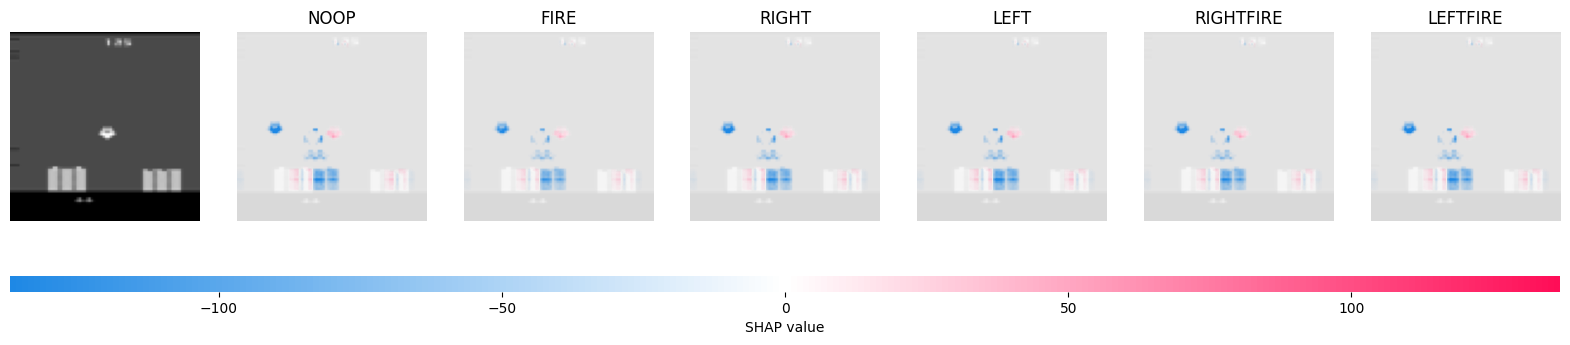

In [3]:
sims = ['ALE/AirRaid-v5', 
'ALE/Asterix-v5', 
'ALE/Asteroids-v5', 
'ALE/Bowling-v5', 
'ALE/Breakout-v5',
'ALE/DemonAttack-v5',
'ALE/Freeway-v5',
'ALE/Gravitar-v5',
'ALE/Jamesbond-v5',
'ALE/MontezumaRevenge-v5',
'ALE/MsPacman-v5',
'ALE/Pong-v5',
'ALE/PrivateEye-v5',
'ALE/Qbert-v5',
'ALE/Seaquest-v5'
'ALE/SpaceInvaders-v5',
'ALE/Venture-v5',
'ALE/WizardOfWor-v5',
'ALE/YarsRevenge-v5',
'ALE/Zaxxon-v5']

for sim in sims:
    sim_name = sim # obs_type="ram", frameskip=4, repeat_action_probability=0.25
    print(sim_name.upper())
    # stella emulator for atari = https://stella-emu.github.io/
    # https://stella-emu.github.io/docs/index.html#Remapping:~:text=count%20and%20associated-,frames%20per%20second,-%2C%20bankswitch%20and%20display
    # assume 60 fpS

    capacity = [1000000, 500000, 100000, 50000, 10000, 5000, 1000, 500]
    labels = ['1M', '500k', '100k', '50k', '10k', '5k', '1k', '500']

    episodes = 20 #200
    n = 10 # n-steps
    samples = 200 #step samples to take per episode
    bat = 128 + 26 #training batches randomly sampled from experience replay + extra samples to accommodate shap training
    rw = 10 # reward window (e.g 100 steps)
    shap_test_sample_ratio = 0.20 # e.g 10%

    #create table for evaluating capacity against reward
    df_rewards = pd.DataFrame(columns=['sim','capacity', 'episodes', 'reward'])

    filename = sim_name.replace("/", "_")

    for i, cap in enumerate(capacity):
        #get current timestamp
        start_datetime = datetime.datetime.now()
        start_datetime = start_datetime.strftime("%Y-%m-%d %H:%M:%S")# Format the date and time as a string
        print("EXPERIMENT " + str(i) + ": Date-Time: " + str(start_datetime) + ", Capacity: " + str(labels[i]))
        
        #### Setup Preprocessed Environment
        print("Setting up environment")
        #env = gym.make('ALE/SpaceInvaders-v5')
        #We first preprocess the image by applying a greyscale and reducing the size to 80px.
        title = sim_name[4:-3]
        env = ImagePreprocessor(gym.make(sim_name), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'
        state, info = env.reset(seed=42)
        
        ##### Create DCQL Agent
        print("Creating Agent with capacity set to: " + str(cap))
        a = env.action_space.n # actions
        g = 0.99 #gamma
        c = cap #1000000 #10000 #memory capacity
        b = bat #training batches #128
        l = 0.001 #learning rate
        t = 1.0 #softmax policy temperature rate (tau). T controls the level of randomness or exploration in the action selection process. T is temperature high, meaning other actions are more explored
    
        
        #Build the Agent
        cnn = CNN(a)
        softmax = SoftmaxPolicy(T=t) 
        agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

        # Set up Experience Replay
        n_steps = NStepProgress(env=env, ai=agent, n_step=n) #instead of learning every transition we learn every nth transition
        memory = ReplayMemory(n_steps=n_steps, capacity=c) #store the last c steps in memory e.g 1millm 500k etc.

        #set learning parameters
        loss = nn.MSELoss()#calculate mean squared error loss
        optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

        ma = MA(rw) #used to get the average of the last n-step rewards

        # Initialize an empty list to store the sampled inputs for SHAP Explainer
        # set a sampling rate based on episodes as batches could be zero if not enough available at start

        #define a random selection size such as 10%
        random_select_size = math.ceil(episodes * shap_test_sample_ratio) 

        # Create an array of random episode numbers
        random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

        # Initialize an empty list to store the sampled inputs for SHAP Explainer
        sampling_episode = []
        sampled_inputs = []
        sampled_targets = []
        episode_sampled = False

        #### Simulate the environment
        print("Simulating environment")
        for episode in range(episodes):
            #run the game for 200 runs of 10 steps and push sample transitions into memory
            memory.run_steps(steps=samples) # e.g 200 steps sampled per episode
            #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
            for batch in memory.sample_batch(b): #b= e.g 128 batches
                #agent training

                #creates the training set for the agent, 
                # we get target discounted q values for the first state in the batch over 10 steps
                inputs, targets = eligibility_trace(batch, cnn, g)

                #We take some training samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
                if episode in random_episodes and not episode_sampled:
                    sampling_episode.append(episode) #record when sample was taken
                    sampled_inputs.append(inputs)
                    sampled_targets.append(targets)
                    episode_sampled = True # Set the flag to True
                else:
                    #we convert them to tensor variables
                    inputs, targets = Variable(inputs), Variable(targets)
                    #like during eligibility_trace we get predicted q values from the cnn model
                    predictions = cnn(inputs)
                    loss_error = loss(predictions, targets)
                    optimizer.zero_grad()
                    loss_error.backward()
                    optimizer.step()
            
            episode_sampled = False # Reset the flag for the next iteration
                    
            rewards_steps = n_steps.rewards_steps() # accumulated reward per 200 steps
            ma.add(rewards_steps) #100 rewards kept

            avg_reward = round(ma.average(),2) #average 100 rewards
            print("Episode: %s, Reward: %s" % (str(episode), str(avg_reward)))
            
            #save rewards per given nth step
            new_row = [title, labels[i], episode, avg_reward]
            df_rewards.loc[len(df_rewards)] = new_row
        env.close()

        #get end timestamp
        end_datetime = datetime.datetime.now()
        end_datetime = end_datetime.strftime("%Y-%m-%d %H:%M:%S")# Format the date and time as a string
        print("END - Date-Time: " + str(end_datetime))

        print("Saving SHAP graphs")
        #### Shap graphs
        #took 10% of total episodes played as sample experience replay to be used as shap training/test data. So if 200 episodes we took 20 episodes. The agent has not seen these images yet
        print(str(len(sampled_inputs)) + " test images available:")

        print("Episodes samples were taken from:")
        print(sampling_episode)
        
        #convert sample states into PIL images
        sampled_inputs_reshaped = []
        for tensor in sampled_inputs:
            # Convert tensor to numpy array and reshape
            image_array = tensor.numpy().squeeze()  # Remove singleton dimensions
        
            # Convert the numpy array to a PIL Image
            pil_image = Image.fromarray((image_array * 255).astype(np.uint8), mode='L')  # Convert to grayscale
            sampled_inputs_reshaped.append(pil_image)
        
        #shap training set
        print("Shap training set: ")
        mask = sampled_inputs_reshaped[::2] #get all even images from index zero as training
        print(len(mask))

        #  turning mask to pytorch dataset then into tensors
        mask = CustomMask(mask, transforms=transforms.ToTensor())
        print("Masks created:")
        print(len(mask))
        
        print("Moving CNN to GPU and creating a mask loader")
        # Move the model to the same device as the input data
        cnn.to(device)

        # Convert the model weights to the same data type as the input data
        cnn.float()  # Or whatever appropriate data type

        #  creating dataloader for mask
        mask_loader = DataLoader(mask, batch_size=10)

        print("Training Deep SHAP Explainer please wait...")
        #  creating explainer for model behaviour
        for images in mask_loader:
            images = images.to(device)
            explainer = shap.DeepExplainer(cnn, images)
            break

        print("Generating SHAP images and saving...")
        #  converting image to tensor
        test_images = sampled_inputs_reshaped[1::2] # get all odd values from index 1 to use as test images
        test_episodes = sampling_episode[1::2]
        for t, test_image in enumerate(test_images):
            
            image = transforms.ToTensor()(test_image)
            image = image.to(device)

            #  deriving shap values for image of interest based on model behaviour
            shap_values = explainer.shap_values(image.view(-1, 1, 80, 80))

            #  preparing for visualization by changing channel arrangement
            shap_numpy = [np.swapaxes(np.swapaxes(x, 1, -1), 1, 2) for x in shap_values]
            image_numpy = np.swapaxes(np.swapaxes(image.view(-1, 1, 80, 80).cpu().numpy(), 1, -1), 1, 2)
            shap_fig = plt.figure()
            #  producing shap plots
            shap.image_plot(shap_numpy, image_numpy, show=False, labels=env.unwrapped.get_action_meanings())
            plt.savefig("./../plots/shap/" + filename +"_"+ str(labels[i]) + "_shap_ep_"+ str(test_episodes[t]) +".png")
            plt.close()

        print("Saving Reward Graphs...")
        #### reward/episode graph
        # Save and plot reward
        reward_fig = plt.figure()
        rewards_data = df_rewards[df_rewards['capacity'] == labels[i]]['reward'].values
        plt.title(title.capitalize() + ": " + str(labels[i]))
        plt.xlabel("Episodes")
        plt.ylabel("Average Reward/" + str(rw) + " steps")
        plt.plot(rewards_data)

        # Draw a vertical line at the optimal point
        plt.axhline(y=round(np.mean(rewards_data),2), color='r', linestyle='--', label='Optimal Point')

        # Draw red dots at the sampled experiences SHAP values will appear from
        plt.scatter(test_episodes, [rewards_data[exp] for exp in test_episodes],
                    marker='x', color='r', label='Experience Sampled', zorder=5)

        plt.tight_layout()
        reward_fig.savefig("./../plots/rewardplots/" + filename +"_"+ str(labels[i]) + "_reward.png") #must be before show to save correctly
        #plt.show()
        plt.close()

        print("Saving Q-value/action graphs...")
        #### Q-values/Actions Taken/Episode graph

        #save and plot q-values from sampled experience
        # Iterate through sampled_targets

        test_targets = sampled_targets[1::2]
        action_labels = env.unwrapped.get_action_meanings()
        
        for s in range(len(test_targets)):
            # Define a list of line styles and colors for each action
            line_styles = ['-', '--', ':', '-.']
            line_colors = ['b', 'g', 'r', 'c']

            # Create a figure
            qvalue_fig = plt.figure(figsize=(10, 5))

            # Iterate through the actions
            for al in range(len(action_labels)):
                # Initialize an empty array to store the y-values for this action
                y_values = []

                # Extract the y-values for the current action 'i' from all series
                for st in range(len(test_targets)):
                    y_values.append(np.array(test_targets[st][0][al]))

                # Create a line plot for this action using all series' y-values
                plt.plot(test_episodes, y_values, label='Action ' + str(action_labels[al]),
                        linestyle=line_styles[al % len(line_styles)], color=line_colors[al % len(line_colors)])

                # Set the labels and title
                plt.title('State: '+ str(test_episodes[s]))
                plt.xlabel('Episodes')
                plt.ylabel('Q-values')

                # Draw a vertical line at sample point point
                plt.axvline(x=test_episodes[s], color='r', linestyle='--', label='State: '+ str(test_episodes[s]))

                # Set x-axis ticks for each value in test_episodes
                plt.xticks(test_episodes,  rotation=90)

                # Add a legend
                plt.legend()

                plt.tight_layout()

                # Save the line chart to a file
                qvalue_fig.savefig("./../plots/qvalueplots/" + filename +"_"+ str(labels[i]) + "_qvalues_ep_"+ str(test_episodes[s]) +".png")
                
                # Display the line chart
                #plt.show()
                plt.close()

        #### reward graph showing sample points
        for s in range(len(test_targets)):
        
            # Save and plot reward
            reward_test_fig = plt.figure(figsize=(5, 5))
            plt.title(title.capitalize() + ": " + str(labels[i]))
            plt.xlabel("Episodes")
            plt.ylabel("Average Reward/" + str(rw) + " steps")
            plt.plot(rewards_data)

            # Draw a vertical line at sample point point
            plt.axvline(x=test_episodes[s], color='r', linestyle='--', label='State: '+ str(test_episodes[s]))

            # Draw red dots at the sampled experiences
            plt.scatter(test_episodes, [rewards_data[exp] for exp in test_episodes],
                            marker='x', color='r', label='Experience Sampled', zorder=5)
        
            plt.tight_layout()
            reward_test_fig.savefig("./../plots/rewardtest/" + filename +"_"+ str(labels[i]) + "_reward_ep_"+ str(test_episodes[s]) +".png") #must be before show to save correctly
            #plt.show()
            plt.close()

        #CREATE SHAP GIF
        # List to store frames for the GIF
        gif_frames = []

        for s in range(len(test_targets)):
            # Load images
            reward_sample = Image.open('./../plots/rewardtest/ALE_SpaceInvaders-v5_'+ str(labels[i]) +'_reward_ep_' + str(test_episodes[s]) +'.png') 
            q_values = Image.open('./../plots/qvalueplots/ALE_SpaceInvaders-v5_' + str(labels[i]) + '_qvalues_ep_' + str(test_episodes[s]) +'.png')
            shap_values = Image.open('./../plots/shap/ALE_SpaceInvaders-v5_'+ str(labels[i]) +'_shap_ep_' + str(test_episodes[s]) + '.png')

            # Get dimensions of input images
            rs_width, rs_height = reward_sample.size  # Assuming the square images have the same dimensions
            qv_width, qv_height = q_values.size
            s_width, s_height = shap_values.size
            new_width = s_width
            new_height = (s_height*2)

            # Create a new image with the calculated dimensions
            new_image = Image.new('RGB', (new_width, (new_height)), (255, 255, 255))


            # Paste the square images on top
            new_image.paste(reward_sample, (240, 0))
            new_image.paste(q_values, (310 + s_width - rs_width - qv_width, 1))

            # Paste the landscape image on the bottom
            new_image.paste(shap_values, (0, s_height+10))

            # Save the new image
            new_image.save('./../plots/shapexplainer/ALE_SpaceInvaders-v5_'+ str(labels[i]) +'_ep_' + str(test_episodes[s]) +'.png')

            #pil_image = Image.open('images/thumbnail.webp')
            #display(new_image)

            #add image to gif array
            gif_frames.append(new_image)

        # Save the list of frames as a GIF
        gif_frames[0].save('./../plots/shapexplainer/ALE_SpaceInvaders-v5_'+ str(labels[i]) +'_shap.gif', save_all=True, append_images=gif_frames[1:], loop=0, duration=200)
        #gif_frames[0].show()
            
    print("Saving rewards to csv")
    x = datetime.datetime.now()
    file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_" + filename + ".csv"
    df_rewards.to_csv(file_name, index=False, encoding='utf-8')

    # Create a box plots using Seaborn for Evaluation
    boxplot_fig = plt.figure()
    unique_capacities = df_rewards['capacity'].unique()

    print("Saving boxplot of results")
    #### Agent's final score to determine how it performed
    average_accumulated_reward = round(sum(df_rewards['reward'].values),0)
    print("Average Accumulated Reward: " + str(average_accumulated_reward))
    num_unique_capacities = len(unique_capacities)
    p = []
    for c in range(num_unique_capacities):
        if c<1:
            p.append('#FFF380')
        else:
            p.append('#8FD9F6')

    ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, width=0.5,
                    palette=p)  # Specify colors for each box

    # Adding labels and title to the plot
    ax.set(ylabel='Average Reward/' + str(rw) + ' steps', xlabel='Experience Replay Capacity',
        title=title.capitalize() + ": " + str(episodes) + " episodes")  # Set labels and title for the axes

    # Calculate the average value for the first box plot
    average_value = df_rewards[df_rewards['capacity'] == df_rewards['capacity'].unique()[0]]['reward'].mean()

    plt.tight_layout()
    boxplot_fig.savefig("./../plots/boxplot/" + filename +".png") #must be before show to save correctly
    # Show the plot
    #plt.show()
    plt.close()
